In [21]:
'''
项目内容：基于卷积神经网络的多个情感特感特征的抽取（TREC问卷数据集上，共有6类情感特征）
'''
import os
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
#使用torchtext构建语料库，
from torchtext.legacy import data,datasets
import random
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic=True
#使用spacy这个标记器将连续的字符串标记，不设置默认情况是将字符串拆分为空格，后面的language表示的是我们的使用的拆分模型
TEXT=data.Field(tokenize='spacy',tokenizer_language='en_core_web_sm')
#使用Pytorch进行muticlass的处理的时候，输出层的维度同类别的数目相同，同时在定义数据类型的时候不再是dtype=torch.float，PyTorch expects the labels to be numericalized LongTensors.
LABEL=data.LabelField()
train_data,test_data=datasets.TREC.splits(TEXT,LABEL,fine_grained=False)
train_data,valid_data=train_data.split(random_state=random.seed(SEED))

In [22]:
#查看数据集中的例子
vars(train_data[-1])

{'text': ['What', 'is', 'a', 'Cartesian', 'Diver', '?'], 'label': 'DESC'}

In [23]:
#建立词汇表build_vocab
MAX_VOCAB_SIZE = 25_000
TEXT.build_vocab(train_data,
                 max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

In [24]:
'''
数据集的描述：
HUM for questions about humans
ENTY for questions about entities
DESC for questions asking you for a description
NUM for questions where the answer is numerical
LOC for questions where the answer is a location
ABBR for questions asking about abbreviations
'''
print(LABEL.vocab.stoi)

defaultdict(None, {'HUM': 0, 'ENTY': 1, 'DESC': 2, 'NUM': 3, 'LOC': 4, 'ABBR': 5})


In [25]:
#设置batch_size，创建迭代器iterator
BATCH_SIZE = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)

In [26]:
import torch.nn as nn
import torch.nn.functional as F
#注意output_dim的设置（2分类问题直接是1，多个类别output_dim同类别的数目相同）
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx):

        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #in_channels image 3 这里处理的是text
        #out_channels filters的数量
        #kernel_size 卷积核的大小 这里使用nn.ModuleList简化代码
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1,
                                              out_channels = n_filters,
                                              kernel_size = (fs, embedding_dim))
                                    for fs in filter_sizes
                                    ])
        #上述用不同大小的卷积核进行了计算，将不同的结果映射到同一个Linear层中，因此是len(filter_sizes) * n_filters
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, text):
        #text = [sent len, batch size]
        text = text.permute(1, 0)
        #text = [batch size, sent len]
        embedded = self.embedding(text)
        #embedded = [batch size, sent len, emb dim]
        #unsqueeze(1) 在1的位置进行升维操作
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        #Maxpool的过程中 每个filter的输出 共有conv.shape[2]个
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = [batch size, n_filters * len(filter_sizes)]
        return self.fc(cat)

In [41]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [2,3]
OUTPUT_DIM = len(LABEL.vocab)
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 801,506 trainable parameters


In [43]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [ 0.1638,  0.6046,  1.0789,  ..., -0.3140,  0.1844,  0.3624],
        ...,
        [-0.3110, -0.3398,  1.0308,  ...,  0.5317,  0.2836, -0.0640],
        [ 0.0091,  0.2810,  0.7356,  ..., -0.7508,  0.8967, -0.7631],
        [-0.6797,  0.2902,  1.7603,  ...,  0.7648,  1.7119, -0.5471]])

In [44]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [45]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [46]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [47]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    loss_list=[]
    count=0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text)
        loss = criterion(predictions, batch.label)
        acc = categorical_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        if(count%10==0):
                loss_list.append(loss.item())
    return epoch_loss / len(iterator), epoch_acc / len(iterator),loss_list

In [48]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    loss_list=[]
    model.eval()
    count=0
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text)
            loss = criterion(predictions, batch.label)
            acc = categorical_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            if(count%10==0):
                loss_list.append(loss.item())
    return epoch_loss / len(iterator), epoch_acc / len(iterator),loss_list

In [49]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [50]:
N_EPOCHS = 30
best_valid_loss = float('inf')
total_loss_list=[]
for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss, train_acc,epoch_train_list = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc ,epoch_test_list= evaluate(model, valid_iterator, criterion)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_loss_list=total_loss_list+epoch_train_list
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 1.207 | Train Acc: 52.14%
	 Val. Loss: 0.846 |  Val. Acc: 70.27%
Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.737 | Train Acc: 74.42%
	 Val. Loss: 0.629 |  Val. Acc: 76.76%
Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.535 | Train Acc: 81.83%
	 Val. Loss: 0.527 |  Val. Acc: 81.86%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.369 | Train Acc: 88.08%
	 Val. Loss: 0.494 |  Val. Acc: 82.52%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.261 | Train Acc: 91.66%
	 Val. Loss: 0.435 |  Val. Acc: 84.59%
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.178 | Train Acc: 94.90%
	 Val. Loss: 0.437 |  Val. Acc: 84.77%
Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 0.134 | Train Acc: 95.61%
	 Val. Loss: 0.429 |  Val. Acc: 85.62%
Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 0.088 | Train Acc: 97.54%
	 Val. Loss: 0.442 |  Val. Acc: 86.23%
Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 0.073 | Train Acc: 97.93%
	 Val. Loss: 0.453 |  Val. Acc: 85.92%
Epoch: 10 | Epoch Time: 0m 2

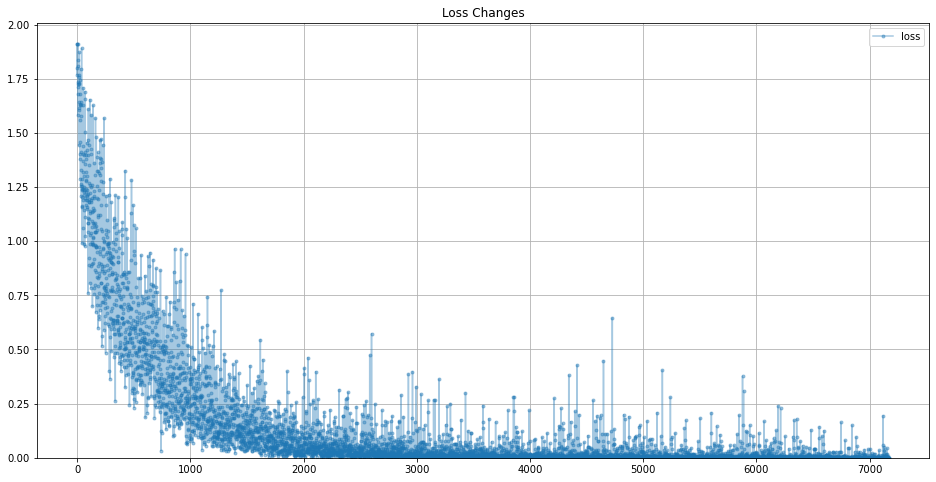

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_progress(progress):
        df = pd.DataFrame(progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.4, marker='.', grid=True)
        plt.title('Loss Changes')
plot_progress(total_loss_list)

In [52]:
model.load_state_dict(torch.load('tut5-model.pt'))
test_loss, test_acc,_ = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.367 | Test Acc: 85.16%


In [53]:
import spacy
nlp = spacy.load('en_core_web_sm')
def predict_class(model, sentence, min_len = 4):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    preds = model(tensor)
    max_preds = preds.argmax(dim = 1)
    return max_preds.item()

In [54]:
pred_class = predict_class(model, "Who is Lauv?")
print(f'Predicted class is: {pred_class} = {LABEL.vocab.itos[pred_class]}')



Predicted class is: 0 = HUM
